# Statistics

Generate statistics from the `csv` files.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import datetime

In [2]:
openssl_dataframe = pandas.read_csv('../openssl_files/results_distinct.csv')
ssh_dataframe = pandas.read_csv('../result_files/results_ssh.csv')
tcp_dataframe = pandas.read_csv('../result_files/results_tcp.csv')

big_dataframe = pandas.concat([openssl_dataframe, ssh_dataframe, tcp_dataframe], join='inner')

## RQ1: Do SMT solvers scale in the state-based comparison of real-world models?


,reference version,updated version,total hours,SMT solver
19,TCP_FreeBSD_Server,TCP_Linux_Server,12.440584,msat
20,TCP_FreeBSD_Server,TCP_Linux_Server,9.002594,msat
21,TCP_FreeBSD_Server,TCP_Linux_Server,19.765870,msat
12,TCP_FreeBSD_Server,TCP_FreeBSD_Server,6.587390,z3
14,TCP_FreeBSD_Server,TCP_FreeBSD_Server,14.005340,z3
26,TCP_FreeBSD_Server,TCP_Linux_Server,6.843588,z3
28,TCP_FreeBSD_Server,TCP_Linux_Server,14.536082,z3
59,TCP_Linux_Server,TCP_FreeBSD_Server,10.785647,z3
60,TCP_Linux_Server,TCP_FreeBSD_Server,15.349598,z3


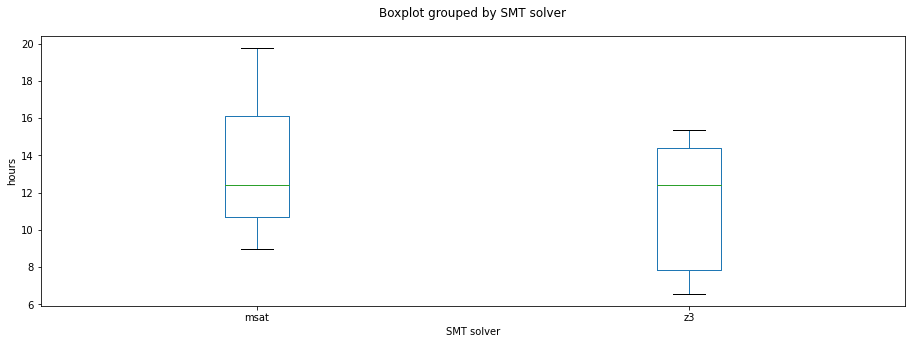

In [163]:
finish_time = datetime.timedelta(hours=6)

unfinshed = big_dataframe[(big_dataframe['incoming time'] + big_dataframe['outgoing time']) >= finish_time.total_seconds()]
unfinshed.insert(2, "total hours", [ (i+j)/3600 for i,j in zip(unfinshed['incoming time'], unfinshed['outgoing time'])])
unfinshed = unfinshed[['reference version', 'updated version', 'total hours', 'SMT solver']]

display(unfinshed.sort_values('SMT solver'))
axs = unfinshed.boxplot(by='SMT solver', grid=False, figsize=(15,5))
axs.set_ylabel("hours")
axs.set_xlabel("SMT solver")
axs.set_title("")
None

## RQ2: Is one SMT solver superior to the other solvers?

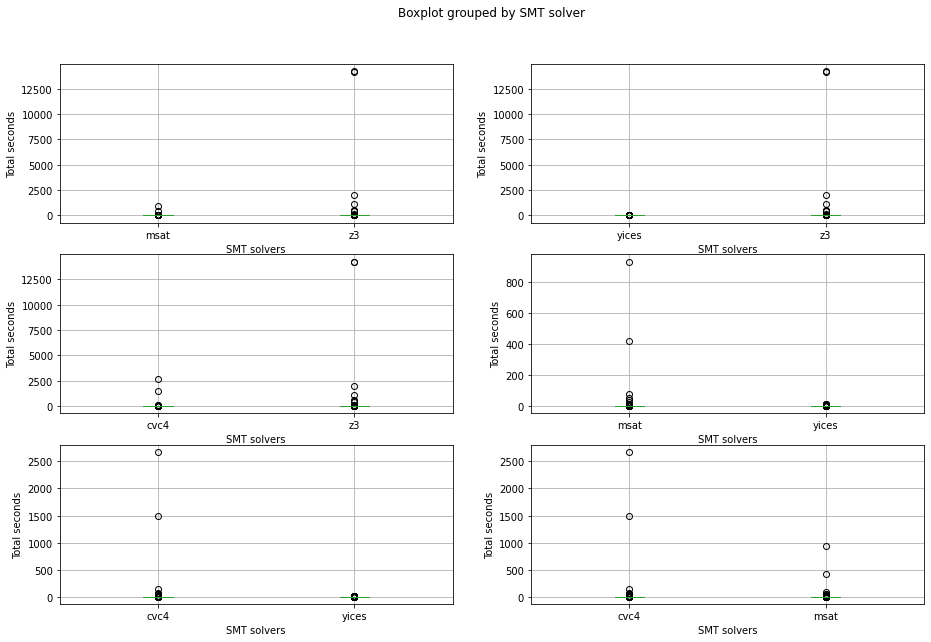

In [164]:
finshed_settings_frame = big_dataframe[(big_dataframe['incoming time'] + big_dataframe['outgoing time']) < finish_time.total_seconds()]
finshed_settings_frame.insert(3,"total seconds", [ (i+j) for i,j in zip(finshed_settings_frame['incoming time'], finshed_settings_frame['outgoing time'])])

average = finshed_settings_frame.groupby(["reference version", "updated version", "SMT solver"]).mean().reset_index()
sample_set = average[["reference version", "updated version", "SMT solver","total seconds"]]

sample_set.insert(2, "count", sample_set.groupby(["reference version", "updated version"])["SMT solver"].transform("count"))

only_finished = sample_set[sample_set["count"] == 4][["reference version", "updated version", "SMT solver","total seconds"]]

fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 10)

def show_finished_box_plot(solver1, solver2, ax):
    only_finished[(only_finished["SMT solver"] == solver1) | (only_finished["SMT solver"] == solver2)].boxplot(by="SMT solver", figsize=(15,5), ax=ax)
    ax.set_xlabel("SMT solvers")
    ax.set_ylabel("Total seconds")
    ax.set_title("")
    

show_finished_box_plot("z3", "msat", axes[0,0])
show_finished_box_plot("z3", "yices", axes[0,1])
show_finished_box_plot("z3", "cvc4", axes[1,0])

show_finished_box_plot("yices", "msat", axes[1,1])
show_finished_box_plot("yices", "cvc4", axes[2,0])

show_finished_box_plot("msat", "cvc4", axes[2,1])

In [ ]:
# Statistical analysis (T-test, Wilcoxon signed-rank test, Effect size)

## RQ3: Does the runtime of the solvers correlate to the size of the model changes?

### RQ3.1: Exection time vs number of state pairs

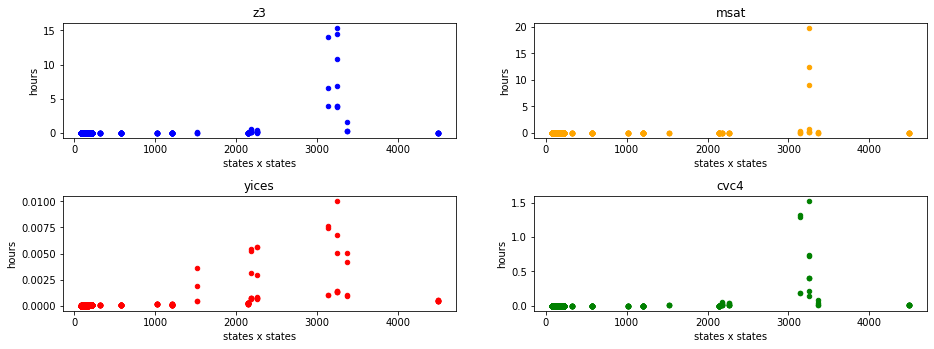

In [36]:
result_frame = big_dataframe[['SMT solver']]
result_frame.insert(1,"states x states",[i*j for i,j in zip(big_dataframe['reference model: number of states'], big_dataframe['updated model: number of states'])])
result_frame.insert(1,"hours",[(i+j)/3600 for i,j in zip(big_dataframe['incoming time'], big_dataframe['outgoing time'])])


fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(15, 5)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

result_frame[result_frame['SMT solver'] == 'z3'].plot.scatter("states x states", "hours", c="blue", subplots=True ,ax=axes[0,0])
axes[0,0].set_title("z3")

result_frame[result_frame['SMT solver'] == 'msat'].plot.scatter("states x states", "hours", c="orange", subplots=True ,ax=axes[0,1])
axes[0,1].set_title("msat")

result_frame[result_frame['SMT solver'] == 'yices'].plot.scatter("states x states", "hours", c="red", subplots=True ,ax=axes[1,0])
axes[1,0].set_title("yices")

result_frame[result_frame['SMT solver'] == 'cvc4'].plot.scatter("states x states", "hours", c="green", subplots=True ,ax=axes[1,1])
axes[1,1].set_title("cvc4")

None

### RQ3.2: Execution time vs performance metrics

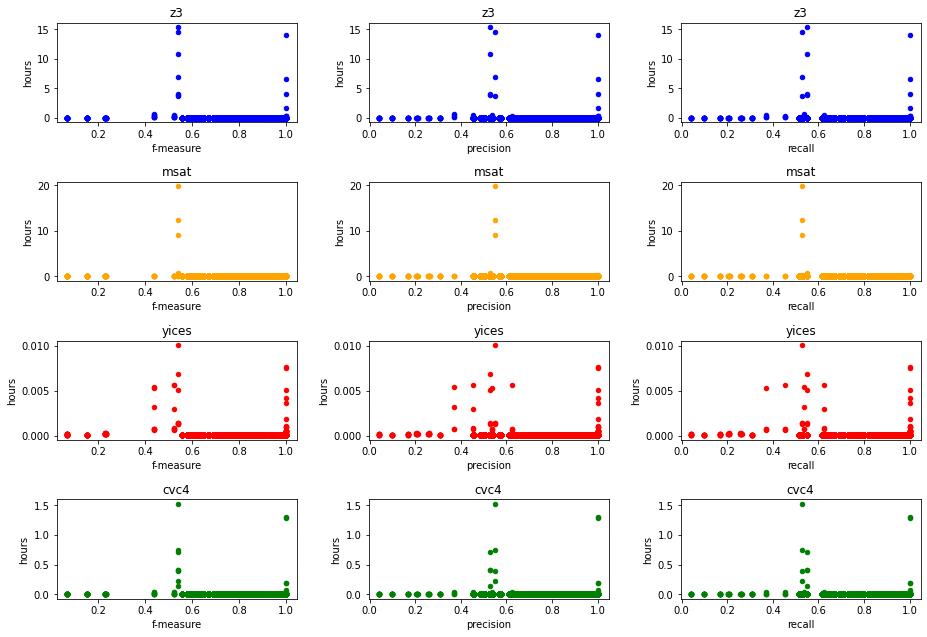

In [34]:
performance_frame = big_dataframe[['SMT solver', 'f-measure', 'precision', 'recall']]
performance_frame.insert(1,"hours",[(i+j)/3600 for i,j in zip(big_dataframe['incoming time'], big_dataframe['outgoing time'])])


fig, axes = plt.subplots(nrows=4,ncols=3)
fig.set_size_inches(15, 10)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.6)

def draw_performance_time_plot(solver, color, row):
    performance_frame[performance_frame['SMT solver'] == solver].plot.scatter("f-measure", "hours", c=color, subplots=True ,ax=axes[row,0])
    axes[row,0].set_title(solver)
    performance_frame[performance_frame['SMT solver'] == solver].plot.scatter("precision", "hours", c=color, subplots=True ,ax=axes[row,1])
    axes[row,1].set_title(solver)
    performance_frame[performance_frame['SMT solver'] == solver].plot.scatter("recall", "hours", c=color, subplots=True ,ax=axes[row,2])
    axes[row,2].set_title(solver)

draw_performance_time_plot("z3", "blue", 0)
draw_performance_time_plot("msat", "orange", 1)
draw_performance_time_plot("yices", "red", 2)
draw_performance_time_plot("cvc4", "green", 3)

None

## RQ4: How does the difference between models change during the evolution of a system?

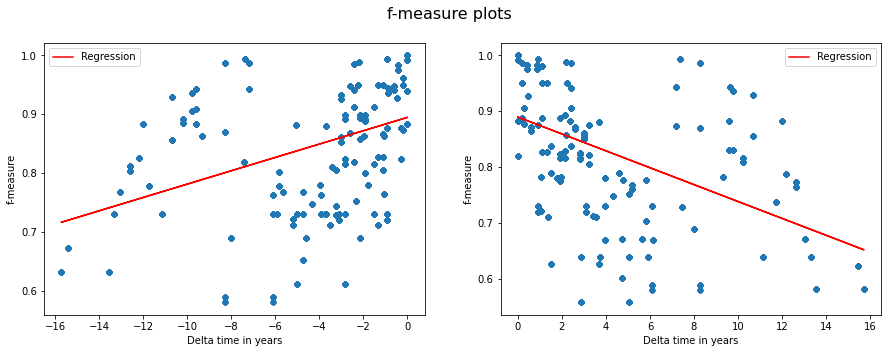

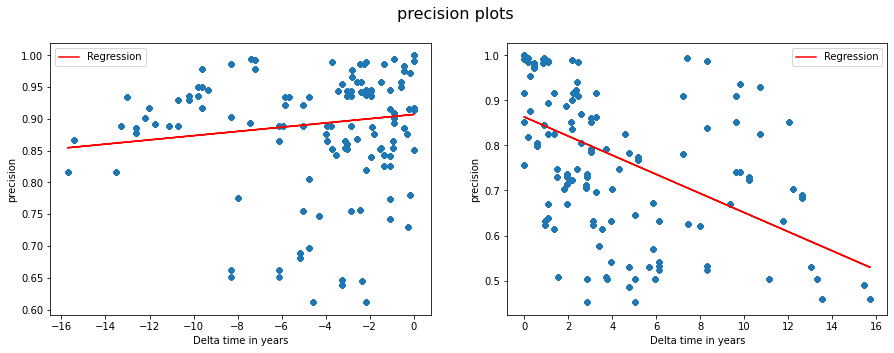

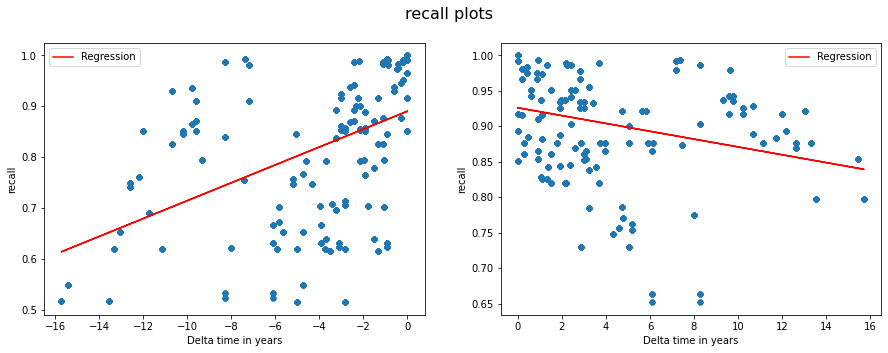

In [35]:
openssl_evolution = openssl_dataframe[openssl_dataframe['SMT solver'] == 'yices']
openssl_evolution.insert(0,'years', [ i/365 for i in openssl_evolution['delta date (days)']])
openssl_evolution = openssl_evolution[['years', 'f-measure', 'precision', 'recall']]


def plot_regression(y_value):
    
    negative = openssl_evolution[openssl_evolution['years'] <= 0]
    positive = openssl_evolution[openssl_evolution['years'] >= 0]

    d = np.polyfit(negative['years'],negative[y_value],1)
    f = np.poly1d(d)
    negative.insert(0,'Regression',f(negative['years']))

    d = np.polyfit(positive['years'],positive[y_value],1)
    f = np.poly1d(d)
    positive.insert(0,'Regression',f(positive['years']))

    fig, axes = plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(15, 5)
    fig.suptitle(y_value + " plots", fontsize=16)
    
    negative.plot.scatter('years', y_value, ax=axes[0], subplots=True)
    negative.plot(x='years', y='Regression',color='Red',ax=axes[0])
    axes[0].set_xlabel("Delta time in years")

    axs = positive.plot.scatter('years', y_value, ax=axes[1], subplots=True)
    positive.plot(x='years', y='Regression',color='Red',ax=axes[1])
    axes[1].set_xlabel("Delta time in years")

plot_regression('f-measure')
plot_regression('precision')
plot_regression('recall')